# Pipeline de video con 8 frames, features agrupadas por video y modelo con capas 3D

Este cuaderno implementa:

- Muestreo uniforme de 8 frames por video, independiente de la duración.
- Extracción de características por frame con una CNN 2D simple (no preentrenada), igual al enfoque de Examen4Deep.
- Agrupación de características por video y guardado en HDF5 por split (train/val/test) incluyendo etiquetas y metadatos.
- Modelo PyTorch que agrega un bloque temporal Conv3D sobre la secuencia de 8 frames, seguido de LSTM+GRU+atención y clasificador.
- Entrenamiento, validación y evaluación con matriz de confusión y reporte de clasificación.

In [ ]:
# Verificar si estamos en Colab
#import sys
#IN_COLAB = 'google.colab' in sys.modules

#if IN_COLAB:
    # Montar Google Drive
 #   from google.colab import drive
  #  drive.mount('/content/drive')

    # Instalar pytorch-lightning si no está instalado
   # !pip install pytorch-lightning

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 62.3 MB/s eta 0:00:00


In [ ]:
# =========================================================
# 🎬 EXTRACCIÓN DE FRAMES EN FORMATO 3D PARA REDES 3D
# =========================================================

import os
import numpy as np
import cv2
import h5py
from tqdm import tqdm
from pathlib import Path

# =========================================================
# 🌱 CONFIGURACIÓN DE SEMILLA PARA REPRODUCTIBILIDAD
# =========================================================
np.random.seed(42)

# =========================================================
# 📦 CONFIGURACIÓN GENERAL
# =========================================================
image_size = (112, 112)       # resolución espacial
num_frames = 8                # frames por video
splits = ['train', 'val', 'test']

videos_base_dir = '/content/drive/MyDrive/Examen'  # base de videos (train/val/test)
output_base_dir = os.path.join(videos_base_dir, 'features_by_video_3d')
os.makedirs(output_base_dir, exist_ok=True)

label_to_int = {}
int_to_label = {}


# =========================================================
# ⚙️ FUNCIONES AUXILIARES
# =========================================================
def uniform_sample_indices(num_frames_total, num_samples=8):
    """Devuelve índices uniformemente distribuidos a lo largo del video."""
    if num_frames_total <= 0:
        return []
    idxs = np.linspace(0, num_frames_total - 1, num_samples).astype(int)
    return idxs.tolist()


def extract_8_frames(video_path, target_size=(112, 112)):
    """Extrae 8 frames redimensionados y normalizados [0,1]."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = uniform_sample_indices(total_frames, num_samples=num_frames)
    frames = []

    for idx in frame_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, target_size)
        frames.append(frame / 255.0)  # normalización

    cap.release()

    if len(frames) < num_frames:
        # Rellenar con último frame si faltan
        while len(frames) < num_frames:
            frames.append(frames[-1])
    return np.array(frames, dtype=np.float32)


def ensure_label_map(split_dir):
    """Genera el mapeo clase→índice globalmente."""
    global label_to_int, int_to_label
    classes = [d.name for d in Path(split_dir).glob('*') if d.is_dir()]
    classes.sort()
    for c in classes:
        if c not in label_to_int:
            idx = len(label_to_int)
            label_to_int[c] = idx
            int_to_label[idx] = c


def process_split(split):
    """Procesa un split (train/val/test) completo."""
    split_dir = os.path.join(videos_base_dir, split)
    if not os.path.isdir(split_dir):
        print(f"[WARN] Split no encontrado: {split_dir}")
        return None

    ensure_label_map(split_dir)

    video_paths, video_labels, video_names = [], [], []
    for class_name in sorted(os.listdir(split_dir)):
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for ext in ('*.mp4', '*.avi', '*.mov', '*.mkv'):
            for vp in Path(class_dir).glob(ext):
                video_paths.append(str(vp))
                video_labels.append(label_to_int[class_name])
                video_names.append(vp.stem)

    print(f"[{split}] Total videos: {len(video_paths)}")

    X_list, y_list, name_list = [], [], []
    for vp, y, name in tqdm(zip(video_paths, video_labels, video_names), total=len(video_paths), desc=f"Extrayendo {split}"):
        frames = extract_8_frames(vp, target_size=image_size)
        if frames is None:
            continue
        X_list.append(frames)
        y_list.append(y)
        name_list.append(name.encode('utf-8'))

    X = np.array(X_list, dtype=np.float32)  # (N, 8, 112, 112, 3)
    y = np.array(y_list, dtype=np.int64)
    names = np.array(name_list, dtype='S')
    labels = np.array([int_to_label[i].encode('utf-8') for i in range(len(int_to_label))], dtype='S')

    out_dir = os.path.join(output_base_dir, split)
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f'{split}_video_frames_3d.hdf5')

    with h5py.File(out_path, 'w') as f:
        f.create_dataset('features', data=X)
        f.create_dataset('labels', data=y)
        f.create_dataset('video_names', data=names)
        f.create_dataset('label_names', data=labels)

    print(f"[{split}] Guardado en: {out_path} → {X.shape}")
    return out_path


# =========================================================
# 🏁 EJECUCIÓN PRINCIPAL
# =========================================================
created_h5 = {}
for sp in splits:
    h5_path = os.path.join(output_base_dir, sp, f'{sp}_video_frames_3d.hdf5')
    if os.path.exists(h5_path):
        print(f"[{sp}] Ya existe: {h5_path} — saltando.")
        created_h5[sp] = h5_path
    else:
        created_h5[sp] = process_split(sp)

print("\n✅ Mapeo de clases generado:")
print(label_to_int)

[train] Ya existe: /content/drive/MyDrive/Examen/features_by_video_3d/train/train_video_frames_3d.hdf5 — saltando.
[val] Ya existe: /content/drive/MyDrive/Examen/features_by_video_3d/val/val_video_frames_3d.hdf5 — saltando.
[test] Ya existe: /content/drive/MyDrive/Examen/features_by_video_3d/test/test_video_frames_3d.hdf5 — saltando.

✅ Mapeo de clases generado:
{}


## ***RED 3D Y LSTM***

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, LSTM, TimeDistributed, BatchNormalization
from tensorflow.keras.optimizers import Adam
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional

# =========================================================
# 🌱 CONFIGURACIÓN DE SEMILLAS PARA REPRODUCTIBILIDAD
# =========================================================
np.random.seed(42)
tf.random.set_seed(42)

# ==========================================
# 📂 FUNCIONES AUXILIARES PARA CARGAR .hdf5
# ==========================================
def load_hdf5(path):
    with h5py.File(path, 'r') as f:
        X = np.array(f['features'])
        y = np.array(f['labels'])
        label_names = np.array(f['label_names']).astype(str)
    return X, y, label_names

# 🔸 AJUSTA ESTAS RUTAS A TUS ARCHIVOS 🔸
train_path = '/content/drive/MyDrive/Examen/features_by_video_3d/train/train_video_frames_3d.hdf5'
val_path   = '/content/drive/MyDrive/Examen/features_by_video_3d/val/val_video_frames_3d.hdf5'
test_path  = '/content/drive/MyDrive/Examen/features_by_video_3d/test/test_video_frames_3d.hdf5'

# ==========================================
# 📥 CARGA LOS DATOS
# ==========================================
X_train, y_train, label_names = load_hdf5(train_path)
X_val, y_val, _ = load_hdf5(val_path)
X_test, y_test, _ = load_hdf5(test_path)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Val shape:   {X_val.shape}, {y_val.shape}")
print(f"Test shape:  {X_test.shape}, {y_test.shape}")
print(f"Clases: {len(label_names)} → {label_names}")

# ==========================================
# ⚖️ NORMALIZACIÓN
# ==========================================
X_train = X_train / np.max(X_train)
X_val   = X_val / np.max(X_val)
X_test  = X_test / np.max(X_test)
# ==========================================
# ⚙️ PARÁMETROS BÁSICOS
# ==========================================
num_classes = 13
frames = 8
height = 112
width = 112
channels = 3

# ==========================================
# 🧠 ARQUITECTURA 3D CNN + LSTM
# ==========================================
model = Sequential([
    # 🧩 Bloque 1
    Conv3D(64, kernel_size=(3,3,3), activation='relu', padding='same', input_shape=(frames, height, width, channels)),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    # 🧩 Bloque 2
    Conv3D(128, kernel_size=(3,3,3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    # 🧩 Bloque 3
    Conv3D(256, kernel_size=(3,3,3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    # 🔁 Paso temporal con LSTM
    TimeDistributed(Flatten()),
    LSTM(256, return_sequences=False, dropout=0.4, recurrent_dropout=0.3),
    Dropout(0.5),

    # 🔚 Clasificación final
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
# ==========================================
# 🔔 CALLBACKS
# ==========================================
checkpoint_path = "/content/drive/MyDrive/Examen/model_3d_best.keras"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]


# ==========================================
# 🧮 COMPILACIÓN
# ==========================================
#optimizer = Adam(learning_rate=3e-4)
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Train shape: (1115, 8, 112, 112, 3), (1115,)
Val shape:   (277, 8, 112, 112, 3), (277,)
Test shape:  (348, 8, 112, 112, 3), (348,)
Clases: 13 → ['Agem_Kanan' 'Agem_Kiri' 'Ngeed' 'Ngegol' 'Ngelo' 'Ngelung' 'Ngeseh'
 'Ngumbang' 'Nyalud' 'Nyeregseg' 'Seledet' 'Tapak_Sirangpada' 'Ulap_Ulap']


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 8, 112, 112,    │         5,248 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 8, 56, 56, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 56, 56, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 8, 56, 56, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 4, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 28, 28, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 4, 28, 28, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 2, 14, 14, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 14, 14, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 2, 50176)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │    51,643,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,825,869 (201.51 MB)

 Trainable params: 52,824,973 (201.51 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# ==========================================
# 🧠 ENTRENAMIENTO CON GUARDADO DEL MEJOR MODELO
# ==========================================

# 📦 Ruta donde se guardará el mejor modelo
best_model_path = "/content/drive/MyDrive/Examen/mejor_modelo_3d_lstm.keras"

# 🧩 Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,            # detiene si no mejora en 10 epochs
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_accuracy',    # puedes usar 'val_loss' si prefieres
    save_best_only=True,
    mode='max',                # 'min' si monitoreas val_loss
    verbose=1
)

# 🚀 Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=4,
    callbacks=callbacks
)

Epoch 1/60
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.2190 - loss: 2.3393
Epoch 1: val_loss improved from inf to 2.37459, saving model to /content/drive/MyDrive/Examen/model_3d_best.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 66s 197ms/step - accuracy: 0.2192 - loss: 2.3386 - val_accuracy: 0.2238 - val_loss: 2.3746 - learning_rate: 1.0000e-04
Epoch 2/60
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3284 - loss: 1.8574
Epoch 2: val_loss improved from 2.37459 to 1.72254, saving model to /content/drive/MyDrive/Examen/model_3d_best.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 49s 174ms/step - accuracy: 0.3284 - loss: 1.8575 - val_accuracy: 0.4188 - val_loss: 1.7225 - learning_rate: 1.0000e-04
Epoch 3/60
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3823 - loss: 1.7311
Epoch 3: val_loss improved from 1.72254 to 1.53527, saving model to /content/drive/MyDrive/Examen/model_3d_best.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 52s 185ms/step - accuracy: 0.3823 - loss: 1.7311 - val_accura

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 529ms/step - accuracy: 0.9858 - loss: 0.0474

🏆 Mejor modelo → Test Accuracy: 98.28% | Test Loss: 0.0481
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step


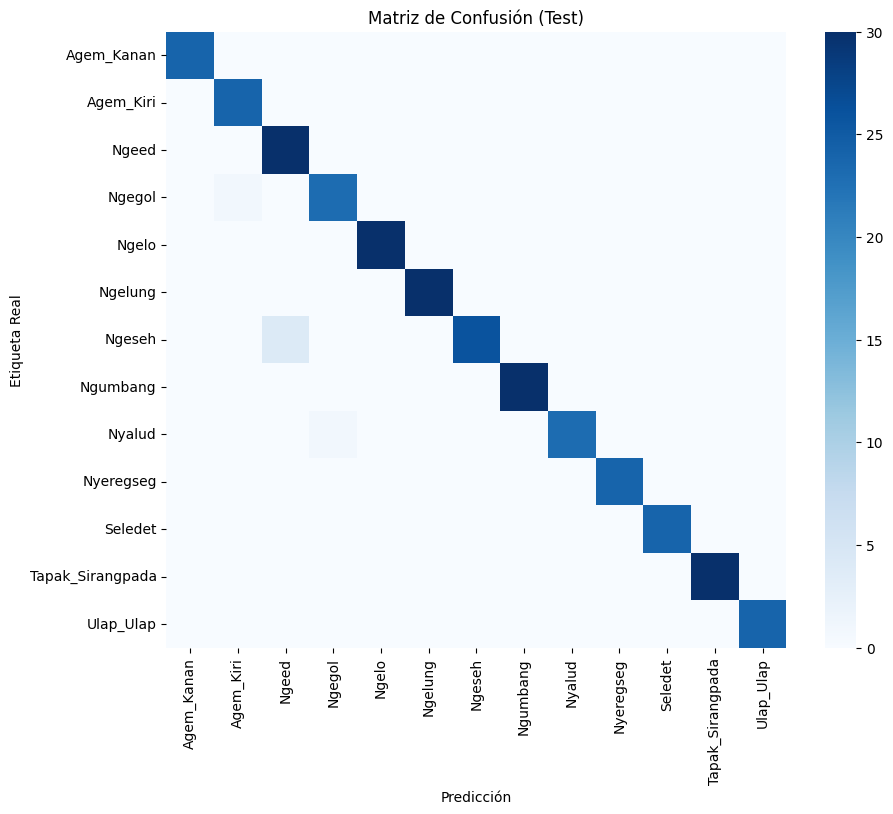


--- Classification Report ---
                  precision    recall  f1-score   support

      Agem_Kanan       1.00      1.00      1.00        24
       Agem_Kiri       0.96      1.00      0.98        24
           Ngeed       0.88      1.00      0.94        30
          Ngegol       0.96      0.96      0.96        24
           Ngelo       1.00      1.00      1.00        30
         Ngelung       1.00      1.00      1.00        30
          Ngeseh       1.00      0.87      0.93        30
        Ngumbang       1.00      1.00      1.00        30
          Nyalud       1.00      0.96      0.98        24
       Nyeregseg       1.00      1.00      1.00        24
         Seledet       1.00      1.00      1.00        24
Tapak_Sirangpada       1.00      1.00      1.00        30
       Ulap_Ulap       1.00      1.00      1.00        24

        accuracy                           0.98       348
       macro avg       0.98      0.98      0.98       348
    weighted avg       0.98      0.98  

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# =========================================================
# 🌱 CONFIGURACIÓN DE SEMILLAS PARA REPRODUCTIBILIDAD
# =========================================================
np.random.seed(42)

# 📦 Ruta donde se guardó el mejor modelo 3D CNN + LSTM
best_model_path = "/content/drive/MyDrive/Examen/model_3d_best.keras"

best_model = load_model(best_model_path)

# ==========================================
# 🧪 EVALUACIÓN EN TEST
# ==========================================
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)
print(f"\n🏆 Mejor modelo → Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")

# ==========================================
# 🔮 PREDICCIONES
# ==========================================
y_pred = np.argmax(best_model.predict(X_test), axis=1) # Use best_model for prediction

# ==========================================
# 🧾 MATRIZ DE CONFUSIÓN
# ==========================================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title("Matriz de Confusión (Test)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()

# ==========================================
# 📋 REPORTE DE CLASIFICACIÓN
# ==========================================
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))

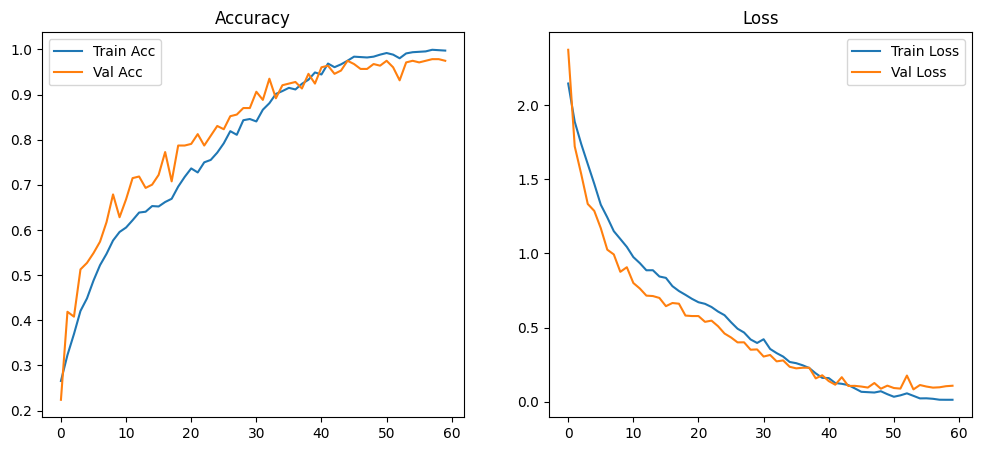

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()
